# Load libraries

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [83]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [14]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.grid_search import GridSearchCV

# Read train and test data

In [4]:
dfXtrain = pd.read_csv('X.train.csv')
dfXtest = pd.read_csv('X.test.csv')
dfYtrain = pd.read_csv('y.train.csv')
Xtrain = np.array(dfXtrain)
Xtest = np.array(dfXtest)

ytrain = np.array(dfYtrain['label'])

In [5]:
print('Data size:', dfXtrain.shape)
dfXtrain.head()

Data size: (4099, 1330)


,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V1322,V1323,V1324,V1325,V1326,V1327,V1328,V1329,V1330,V1331
0,826.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,0.0,0.5
1,15.0,0.0,0,0.0,0.0,0.0,0.0,0.030303,0.083333,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0
2,242.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,1.0,1.0,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.5
3,1038.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
4,971.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


In [6]:
meta = pd.read_csv('MetaData.csv')
print('Meta size:', meta.shape)
meta.head()

Meta size: (1330, 3)


,varnum,type,Column Type
0,V2,char,Numeric
1,V3,num,Category
2,V4,num,Category
3,V5,num,Category
4,V6,num,Category


# Replace all NaN's in train and test data to most frequent values in train data

In [7]:
Xbig = np.vstack((Xtrain, Xtest))

In [8]:
imp_first = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
imp_first.fit(Xbig)

Xtrain = imp_first.transform(Xtrain)
Xtest = imp_first.transform(Xtest)

# Train Random Forest classifier

In [9]:
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(Xtrain, ytrain, test_size=0.5)

In [10]:
from sklearn.metrics import log_loss

In [11]:
def get_score_list(X, y, clf):
    predictions = list()
    score = list()
    for i, tree in enumerate(clf.estimators_):
        predictions.append(tree.predict(X))
        rf_prediction = mean(predictions, axis=0)
        score.append(log_loss(y, rf_prediction))
        if i % 100 == 0:
            print(score[-1])
    return score

In [12]:
def plot_score_graph(clf, X_train, X_test, y_train, y_test, prefix, print_train=True):
    clf.fit(X_train, y_train)
    train_score = get_score_list(X_train, y_train, clf)
    test_score = get_score_list(X_test, y_test, clf)
    if print_train:
        plot(train_score, label=prefix + ' train set error')
    plot(test_score, label=prefix + ' test set error')
    xlabel('n_estimators')
    ylabel('LL')
    legend()

1.63509052737
0.0540992053399
0.0541462446235
0.0545018499756
0.0541708345631
0.0540293066663
0.0541581192378
0.0541277888443
0.0540903327771
0.054111425702
4.90288812784
0.24207830467
0.211887177618
0.211706905429
0.212521800228
0.212151221059
0.212442570026
0.212412760684
0.212489535753
0.212386571865


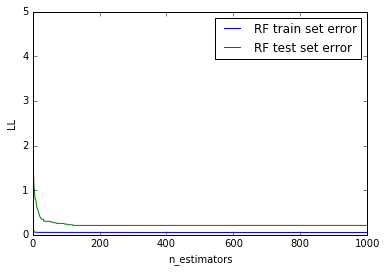

In [13]:
n_estimators = 1000
plot_score_graph(RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', max_features=330, n_jobs=-1),
               X_train[:, :330], X_test[:, :330], y_train, y_test,
               prefix='RF')

1.58452247935
0.0556400395619
0.0548931862961
0.0550467920381
0.0548504765262
0.0547174159817
0.0548698974264
0.0548822075421
0.0547715201285
0.0547594931724
4.24579180507
0.23324960904
0.217467003192
0.217281147971
0.216052779681
0.216215873518
0.216293026619
0.215948544798
0.216118636643
0.216421145675


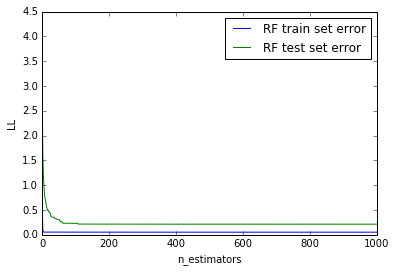

In [19]:
n_estimators = 1000
plot_score_graph(RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', max_features=400, n_jobs=-1),
               X_train, X_test, y_train, y_test,
               prefix='RF')

In [21]:
clf = RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', max_features=400, n_jobs=-1)
clf.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=400, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

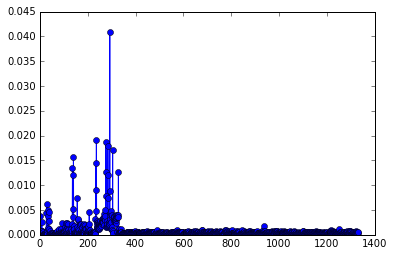

In [22]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plot(importances, '-o')

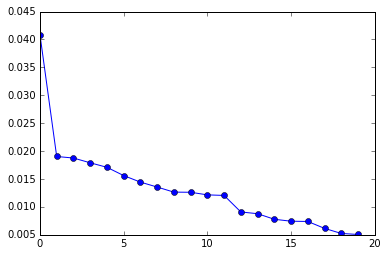

In [69]:
plot(importances[indices[:20]], '-o')

In [25]:
indices

array([292, 236, 276, ...,  45,  46, 194])

In [65]:
len(set(indices[:400]) - set(range(330)))

222

In [66]:
good_features = indices[:400]

1.50023381408
0.0546170105289
0.0545410528707
0.0541293552751
0.0540779272352
0.0541009578233
0.0542251230445
0.0541350724049
0.0541045523885
0.0541501588389
4.12785217953
0.229168436442
0.211832789171
0.210884671526
0.210928139145
0.210446392497
0.210610498218
0.210316749088
0.20977503081
0.210051381358


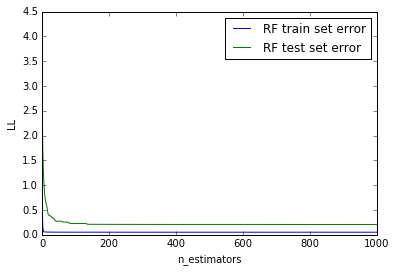

In [67]:
n_estimators = 1000
max_features = None
plot_score_graph(RandomForestClassifier(n_estimators=n_estimators, criterion='entropy',\
                                        max_features=max_features, n_jobs=-1),
               X_train[:, good_features], X_test[:, good_features], y_train, y_test,
               prefix='RF')

In [77]:
def learn(clf, params, features, print_flag=False):
    grid_searcher = GridSearchCV(clf,\
                             params, cv=3, scoring='log_loss', n_jobs=-1)
    grid_searcher.fit(Xtrain[:, features], ytrain)

    if print_flag:
        print(grid_searcher.best_score_)
        print(grid_searcher.best_estimator_)
    
    return grid_searcher

In [84]:
%%time

rfc_searcher = None
best_score = -10
best_num = 0
params = {'max_features': arange(0.09, 1.0, 0.1)}

for num in range(100, 700, 20):
    searcher = learn(RandomForestClassifier(n_estimators=1000, criterion='entropy', n_jobs=-1), params,\
                     indices[:num])
    if searcher.best_score_ > best_score:
        best_score = searcher.best_score_
        rfc_searcher = searcher
        best_num = num
        print(best_num, best_score)

print(best_score)
print(best_num)
print(rfc_searcher.best_estimator_)

100 -0.218942305723
120 -0.217410613324
160 -0.2165839456
180 -0.215434651436
200 -0.214646423172
220 -0.214427477756
260 -0.21426296839
280 -0.214102080948


KeyboardInterrupt: 

In [85]:
print(best_score)
print(best_num)
print(rfc_searcher.best_estimator_)

-0.214102080948
280
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.89000000000000001,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [86]:
clf = rfc_searcher.best_estimator_
clf.fit(Xtrain[:, indices[:best_num]], ytrain)

ypred = clf.predict_proba(Xtest[:, indices[:best_num]])[:, 1]

Сразу в конец, остальное не смотри. А вообще, если зайдёт, можно обучить число первых лучших признаков и max_features.

Попробуем разобраться с генетической информацией

In [93]:
dfX_train = pd.DataFrame(data=Xtrain)
dfX_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1320,1321,1322,1323,1324,1325,1326,1327,1328,1329
0,826.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010101,0.055556,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.5
1,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,0.083333,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0
2,242.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010101,0.055556,0.0,...,1.0,1.0,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.5
3,1038.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010101,0.055556,0.0,...,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
4,971.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010101,0.055556,0.0,...,0.0,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


In [104]:
categorial = dfX_train.columns[meta.ix[:330-1]['Column Type'] == 'Category']
categorial

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            220, 221, 222, 223, 224, 225, 226, 305, 327, 328],
           dtype='int64', length=181)

In [119]:
X_big_encoded = pd.get_dummies(pd.DataFrame(data=np.vstack((Xtrain, Xtest))), columns=categorial).values

X_train_encoded = X_big_encoded[:4099]
print(X_train_encoded.shape)
X_test_encoded = X_big_encoded[4099:]
print(X_test_encoded.shape)

(4099, 1651)
(1366, 1651)


In [125]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_train_encoded, ytrain, test_size=0.5)

1.95536653863
0.0514612351335
0.0519373299816
0.0523675426091
0.0521562095513
0.052199883323
0.0521760462936
0.0520911281056
0.0521320806194
0.0521264198009
4.27949207276
0.240624397806
0.223394998177
0.224145217426
0.224022090824
0.223872866331
0.22336785992
0.223413891248
0.223344731553
0.223699748419


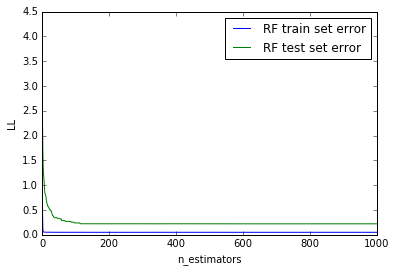

In [126]:
n_estimators = 1000
plot_score_graph(RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', max_features=500, n_jobs=-1),
               X_train, X_test, y_train, y_test,
               prefix='RF')

In [124]:
def learn(clf, params, X, y):
    grid_searcher = GridSearchCV(clf,\
                             params, cv=5, scoring='log_loss', n_jobs=3)
    grid_searcher.fit(X, y)

    print(grid_searcher.best_score_)
    print(grid_searcher.best_estimator_)
    
    return grid_searcher

In [128]:
%%time

params = {'max_features': arange(0.1, 0.8, 0.05)}
rfc_grid_searcher = learn(RandomForestClassifier(n_estimators=n_estimators,\
                        criterion='entropy', n_jobs=-1), params, X_train_encoded, ytrain)

-0.219370292724
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.15000000000000002,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
CPU times: user 3min 54s, sys: 5.63 s, total: 4min
Wall time: 2h 38min 7s


In [129]:
clf = rfc_grid_searcher.best_estimator_
clf.fit(X_train_encoded, ytrain)

ypred = clf.predict_proba(X_test_encoded)[:, 1]

# Save predictions

In [87]:
dfpred = pd.DataFrame()
dfpred['Id'] = np.arange(len(ypred))
dfpred['Prediction'] = ypred

dfpred.to_csv('y.predicted.csv', index = False)